# Importing Libraries

In [1]:
#!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

## Sales forecasting

In [3]:
data = pd.read_csv('merged_data.csv')

In [4]:
data.head()

,OrderNumber,Sales Channel,WarehouseCode,ProcuredDate,OrderDate,ShipDate,DeliveryDate,CurrencyCode,_SalesTeamID,_CustomerID,_StoreID,_ProductID,Order Quantity,Discount Applied,Unit Price,Unit Cost,Product Name
0,SO - 000101,In-Store,WARE-UHY1004,12/31/17,5/31/18,6/14/18,6/19/18,USD,6,15,259,12,5,0.075,"1,963.10","1,001.18",Dining Furniture
1,SO - 000102,Online,WARE-NMK1003,12/31/17,5/31/18,6/22/18,7/2/18,USD,14,20,196,27,3,0.075,"3,939.60","3,348.66",Wreaths
2,SO - 000103,Distributor,WARE-UHY1004,12/31/17,5/31/18,6/21/18,7/1/18,USD,21,16,213,16,1,0.050,"1,775.50",781.22,Stemware
3,SO - 000104,Wholesale,WARE-NMK1003,12/31/17,5/31/18,6/2/18,6/7/18,USD,28,48,107,23,8,0.075,"2,324.90","1,464.69",Accessories
4,SO - 000105,Distributor,WARE-NMK1003,4/10/18,5/31/18,6/16/18,6/26/18,USD,22,49,111,26,8,0.100,"1,822.40","1,476.14",Candles


In [5]:
data.dtypes

OrderNumber          object
Sales Channel        object
WarehouseCode        object
ProcuredDate         object
OrderDate            object
ShipDate             object
DeliveryDate         object
CurrencyCode         object
_SalesTeamID          int64
_CustomerID           int64
_StoreID              int64
_ProductID            int64
Order Quantity        int64
Discount Applied    float64
Unit Price           object
Unit Cost            object
Product Name         object
dtype: object

## Data Pre-Processing

In [6]:
# Convert date columns to datetime
data['OrderDate'] = pd.to_datetime(data['OrderDate'])
data['DeliveryDate'] = pd.to_datetime(data['DeliveryDate'])
data['ShipDate'] = pd.to_datetime(data['ShipDate'])

# Convert 'Unit Price' and 'Unit Cost' to numeric, remove any commas or special characters
data['Unit Price'] = pd.to_numeric(data['Unit Price'].str.replace(',', '').str.replace('$', ''), errors='coerce')
data['Unit Cost'] = pd.to_numeric(data['Unit Cost'].str.replace(',', '').str.replace('$', ''), errors='coerce')

# Calculate Profit and Fulfillment Efficiency
data['Profit'] = data['Unit Price'] - data['Unit Cost']
data['Fulfillment Days'] = (data['DeliveryDate'] - data['ShipDate']).dt.days

# Feature Engineering for Sales Forecasting
data['Year'] = data['OrderDate'].dt.year
data['Month'] = data['OrderDate'].dt.month
data['Order Value'] = data['Order Quantity'] * data['Unit Price'] * (1 - data['Discount Applied'])

data['_ProductID'] = data['_ProductID'].astype(str)

# Display the first few rows to verify changes
data.head()

<ipython-input-6-9d6a59de4a2c>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['OrderDate'] = pd.to_datetime(data['OrderDate'])
<ipython-input-6-9d6a59de4a2c>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['DeliveryDate'] = pd.to_datetime(data['DeliveryDate'])
<ipython-input-6-9d6a59de4a2c>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['ShipDate'] = pd.to_datetime(data['ShipDate'])


,OrderNumber,Sales Channel,WarehouseCode,ProcuredDate,OrderDate,ShipDate,DeliveryDate,CurrencyCode,_SalesTeamID,_CustomerID,...,Order Quantity,Discount Applied,Unit Price,Unit Cost,Product Name,Profit,Fulfillment Days,Year,Month,Order Value
0,SO - 000101,In-Store,WARE-UHY1004,12/31/17,2018-05-31,2018-06-14,2018-06-19,USD,6,15,...,5,0.075,1963.1,1001.18,Dining Furniture,961.92,5,2018,5,9079.3375
1,SO - 000102,Online,WARE-NMK1003,12/31/17,2018-05-31,2018-06-22,2018-07-02,USD,14,20,...,3,0.075,3939.6,3348.66,Wreaths,590.94,10,2018,5,10932.3900
2,SO - 000103,Distributor,WARE-UHY1004,12/31/17,2018-05-31,2018-06-21,2018-07-01,USD,21,16,...,1,0.050,1775.5,781.22,Stemware,994.28,10,2018,5,1686.7250
3,SO - 000104,Wholesale,WARE-NMK1003,12/31/17,2018-05-31,2018-06-02,2018-06-07,USD,28,48,...,8,0.075,2324.9,1464.69,Accessories,860.21,5,2018,5,17204.2600
4,SO - 000105,Distributor,WARE-NMK1003,4/10/18,2018-05-31,2018-06-16,2018-06-26,USD,22,49,...,8,0.100,1822.4,1476.14,Candles,346.26,10,2018,5,13121.2800


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7991 entries, 0 to 7990
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   OrderNumber       7991 non-null   object        
 1   Sales Channel     7991 non-null   object        
 2   WarehouseCode     7991 non-null   object        
 3   ProcuredDate      7991 non-null   object        
 4   OrderDate         7991 non-null   datetime64[ns]
 5   ShipDate          7991 non-null   datetime64[ns]
 6   DeliveryDate      7991 non-null   datetime64[ns]
 7   CurrencyCode      7991 non-null   object        
 8   _SalesTeamID      7991 non-null   int64         
 9   _CustomerID       7991 non-null   int64         
 10  _StoreID          7991 non-null   int64         
 11  _ProductID        7991 non-null   object        
 12  Order Quantity    7991 non-null   int64         
 13  Discount Applied  7991 non-null   float64       
 14  Unit Price        7991 n

## Exploratory Data Analysis

In [8]:
# Grouping by Product Name and aggregating data
product_performance = data.groupby('Product Name').agg({
    'Order Quantity': 'sum',
    'Order Value': 'sum'
}).reset_index()

# Sorting to identify top-performing products based on 'Order Quantity'
top_products = product_performance.sort_values('Order Quantity', ascending=False)

# Format the 'Order Value' column for display
top_products['Order Value'] = top_products['Order Value'].apply(lambda x: '{:,.2f}'.format(x))

# Grouping by Sales Channel
sales_channel_performance = data.groupby('Sales Channel').agg({
    'Order Value': ['sum', 'mean'],
    'OrderNumber': 'count'
}).reset_index()

# Renaming columns for clarity
sales_channel_performance.columns = ['Sales Channel', 'Total Sales', 'Average Order Value', 'Order Count']

# Grouping by Warehouse Code
warehouse_performance = data.groupby('WarehouseCode').agg({
    'Order Value': 'sum',
    'Fulfillment Days': 'mean',
    'OrderNumber': 'count'
}).reset_index()

# Renaming columns for clarity
warehouse_performance.columns = ['Warehouse Code', 'Total Sales', 'Average Fulfillment Days', 'Order Count']


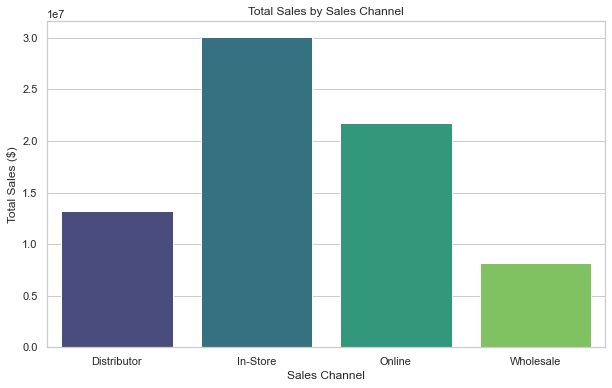

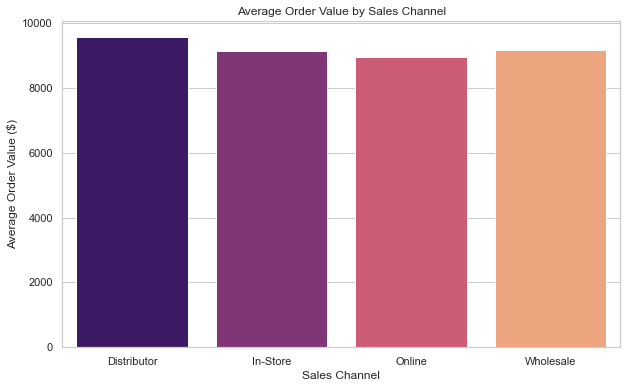

In [9]:
import seaborn as sns

# Set the plot style
sns.set(style="whitegrid")

# Plotting Total Sales by Sales Channel
plt.figure(figsize=(10, 6))
sns.barplot(x='Sales Channel', y='Total Sales', data=sales_channel_performance, palette='viridis')
plt.title('Total Sales by Sales Channel')
plt.ylabel('Total Sales ($)')
plt.xlabel('Sales Channel')
plt.show()

# Plotting Average Order Value by Sales Channel
plt.figure(figsize=(10, 6))
sns.barplot(x='Sales Channel', y='Average Order Value', data=sales_channel_performance, palette='magma')
plt.title('Average Order Value by Sales Channel')
plt.ylabel('Average Order Value ($)')
plt.xlabel('Sales Channel')
plt.show()

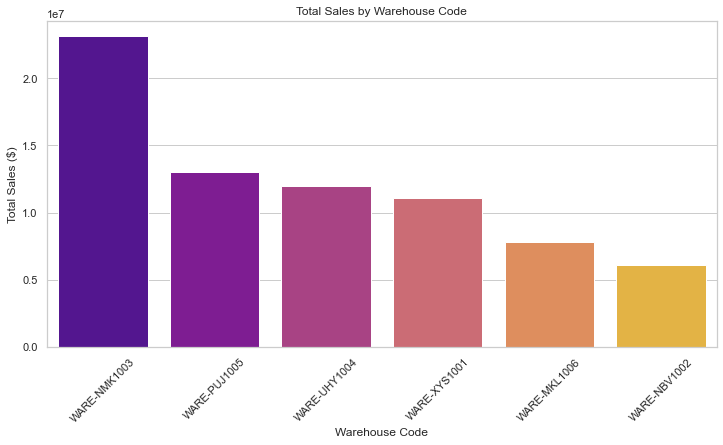

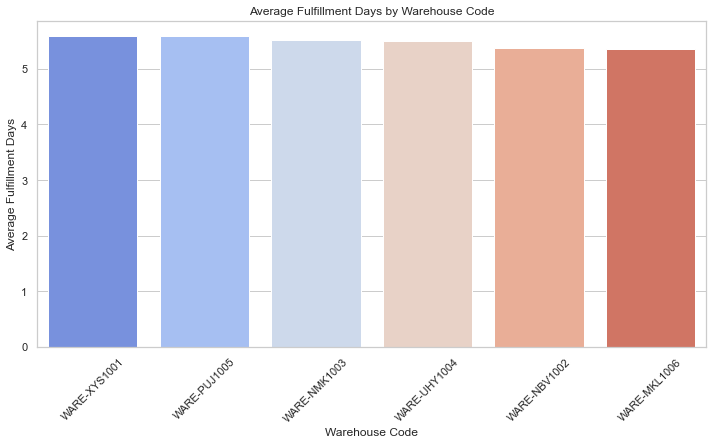

In [10]:
# Plotting Total Sales by Warehouse Code
plt.figure(figsize=(12, 6))
sns.barplot(x='Warehouse Code', y='Total Sales', data=warehouse_performance.sort_values('Total Sales', ascending=False), palette='plasma')
plt.title('Total Sales by Warehouse Code')
plt.ylabel('Total Sales ($)')
plt.xlabel('Warehouse Code')
plt.xticks(rotation=45)
plt.show()

# Plotting Average Fulfillment Days by Warehouse Code
plt.figure(figsize=(12, 6))
sns.barplot(x='Warehouse Code', y='Average Fulfillment Days', data=warehouse_performance.sort_values('Average Fulfillment Days', ascending=False), palette='coolwarm')
plt.title('Average Fulfillment Days by Warehouse Code')
plt.ylabel('Average Fulfillment Days')
plt.xlabel('Warehouse Code')
plt.xticks(rotation=45)
plt.show()

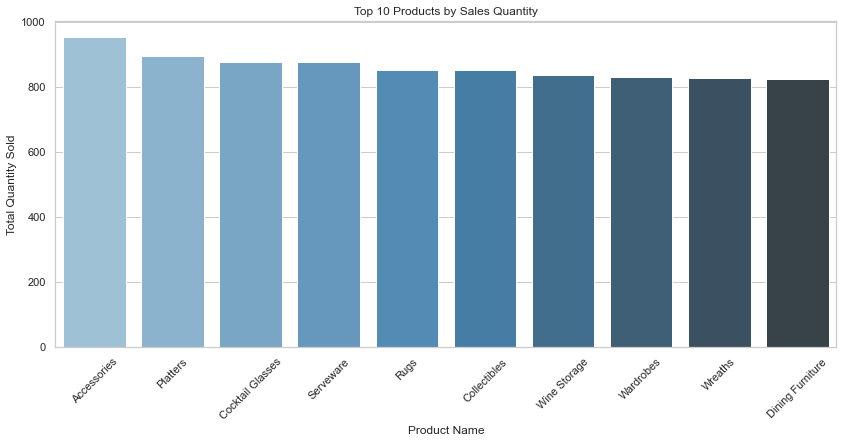

In [11]:
# Plotting Top Products by Sales Quantity
plt.figure(figsize=(14, 6))
sns.barplot(x='Product Name', y='Order Quantity', data=top_products.head(10), palette='Blues_d')
plt.title('Top 10 Products by Sales Quantity')
plt.ylabel('Total Quantity Sold')
plt.xlabel('Product Name')
plt.xticks(rotation=45)
plt.show()

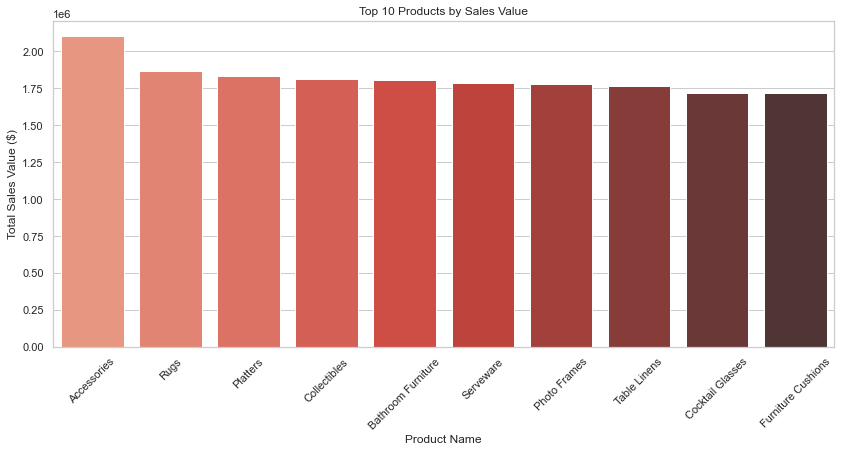

In [12]:
# Sorting to identify top-performing products based on 'Order Value'
top_products = product_performance.sort_values('Order Value', ascending=False)

# Converting the formatted 'Order Value' back to numeric if it was previously formatted
top_products['Order Value'] = pd.to_numeric(top_products['Order Value'])

# Plotting Top Products by Sales Value
plt.figure(figsize=(14, 6))
sns.barplot(x='Product Name', y='Order Value', data=top_products.head(10), palette='Reds_d')
plt.title('Top 10 Products by Sales Value')
plt.ylabel('Total Sales Value ($)')
plt.xlabel('Product Name')
plt.xticks(rotation=45)
plt.show()

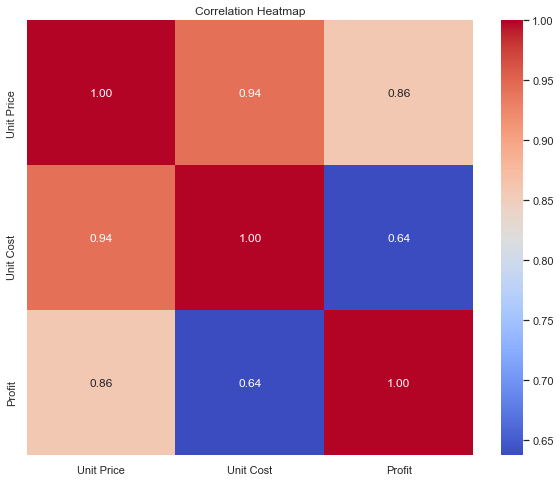

In [13]:
# Calculate correlation matrix
corr_matrix = data[['Unit Price', 'Unit Cost', 'Profit']].corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## Model Building

In [14]:
data['_ProductID'].unique()

array(['12', '27', '16', '23', '26', '1', '5', '46', '47', '13', '38',
       '40', '39', '32', '6', '25', '3', '20', '24', '33', '35', '15',
       '36', '37', '14', '7', '17', '2', '34', '11', '8', '44', '22', '4',
       '45', '21', '10', '28', '29', '18', '30', '31', '43', '9', '41',
       '19', '42'], dtype=object)

### Sorting the data for a specific product

In [15]:
product_id = '7'

product_data = data[data['_ProductID'] == product_id]

product_data

,OrderNumber,Sales Channel,WarehouseCode,ProcuredDate,OrderDate,ShipDate,DeliveryDate,CurrencyCode,_SalesTeamID,_CustomerID,...,Order Quantity,Discount Applied,Unit Price,Unit Cost,Product Name,Profit,Fulfillment Days,Year,Month,Order Value
32,SO - 000133,Online,WARE-UHY1004,12/31/17,2018-06-03,2018-06-30,2018-07-10,USD,19,46,...,3,0.100,3919.5,2077.34,Dinnerware,1842.16,10,2018,6,10582.6500
148,SO - 000249,Distributor,WARE-MKL1006,4/10/18,2018-06-17,2018-07-02,2018-07-04,USD,21,50,...,7,0.050,227.8,100.23,Dinnerware,127.57,2,2018,6,1514.8700
179,SO - 000280,Wholesale,WARE-XYS1001,4/10/18,2018-06-21,2018-07-04,2018-07-07,USD,25,40,...,5,0.200,1139.0,933.98,Dinnerware,205.02,3,2018,6,4556.0000
206,SO - 000307,Online,WARE-PUJ1005,4/10/18,2018-06-26,2018-07-20,2018-07-22,USD,12,1,...,1,0.075,1078.7,506.99,Dinnerware,571.71,2,2018,6,997.7975
306,SO - 000407,Wholesale,WARE-MKL1006,4/10/18,2018-07-07,2018-07-13,2018-07-16,USD,28,38,...,1,0.300,1842.5,1050.23,Dinnerware,792.27,3,2018,7,1289.7500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7793,SO - 0007894,Online,WARE-XYS1001,9/26/20,2020-12-07,2020-12-26,2021-01-05,USD,14,29,...,2,0.150,1125.6,866.71,Dinnerware,258.89,10,2020,12,1913.5200
7799,SO - 0007900,Online,WARE-NMK1003,9/26/20,2020-12-07,2020-12-19,2020-12-22,USD,14,48,...,5,0.100,2224.4,1557.08,Dinnerware,667.32,3,2020,12,10009.8000
7821,SO - 0007922,Distributor,WARE-NMK1003,6/18/20,2020-12-09,2021-01-02,2021-01-11,USD,23,12,...,1,0.100,1078.7,744.30,Dinnerware,334.40,9,2020,12,970.8300
7907,SO - 0008008,Distributor,WARE-XYS1001,9/26/20,2020-12-21,2021-01-04,2021-01-14,USD,21,25,...,5,0.200,6210.9,3540.21,Dinnerware,2670.69,10,2020,12,24843.6000


## Initial Model

In [16]:
# Assuming 'product_data' is already defined with the correct columns
#features = ['Year', 'Month', 'Fulfillment Days', 'Discount Applied', 'Profit', 'Order Quantity']
features = ['Year', 'Month', 'Discount Applied', 'Order Quantity']
target = 'Order Value'

X = product_data[features]
y = product_data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and fit XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)

# Build and fit RandomForest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)

# Evaluate both models
xgb_mse = mean_squared_error(y_test, xgb_y_pred)
xgb_mae = mean_absolute_error(y_test, xgb_y_pred)

rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_mae = mean_absolute_error(y_test, rf_y_pred)

# Display results and metrics
print(f"XGBoost Model Metrics:")
print(f"Mean Squared Error (MSE): {xgb_mse}")
print(f"Mean Absolute Error (MAE): {xgb_mae}\n")

print(f"Random Forest Model Metrics:")
print(f"Mean Squared Error (MSE): {rf_mse}")
print(f"Mean Absolute Error (MAE): {rf_mae}\n")

# Compare and choose the better model
if xgb_mae < rf_mae:
    print("XGBoost is the better model based on MAE.")
    best_model_initial = xgb_model
    model_initial = 'XGBoost'
else:
    print("Random Forest is the better model based on MAE.")
    best_model_initial = rf_model
    model_initial = 'Random Forest'

XGBoost Model Metrics:
Mean Squared Error (MSE): 65178710.720785886
Mean Absolute Error (MAE): 5752.446095437444

Random Forest Model Metrics:
Mean Squared Error (MSE): 58715638.16039889
Mean Absolute Error (MAE): 5252.890872457184

Random Forest is the better model based on MAE.


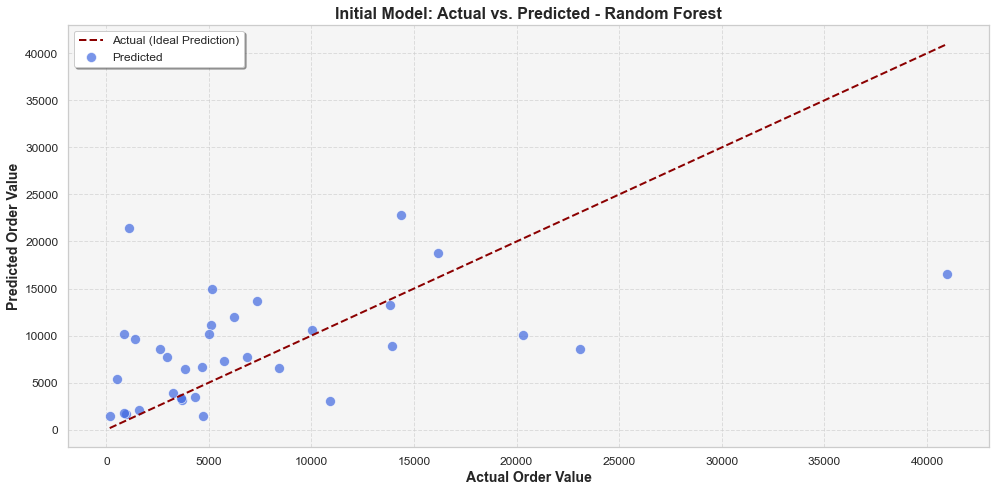

In [17]:
# Predict using the best model
y_pred_initial = best_model_initial.predict(X_test)

# Prepare data for plotting
results_initial = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_initial})

# Plotting
plt.figure(figsize=(14, 7))

# Scatter plot for predicted vs actual values
sns.scatterplot(x='Actual', y='Predicted', data=results_initial, color='royalblue', s=100, edgecolor='w', alpha=0.7, label='Predicted')

# Line plot for ideal prediction
sns.lineplot(x=results_initial['Actual'], y=results_initial['Actual'], color='darkred', linewidth=2, linestyle='--', label='Actual (Ideal Prediction)')

# Enhancing plot appearance
plt.title(f'Initial Model: Actual vs. Predicted - {model_initial}', fontsize=16, fontweight='bold')
plt.xlabel('Actual Order Value', fontsize=14, fontweight='bold')
plt.ylabel('Predicted Order Value', fontsize=14, fontweight='bold')

# Adding gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Customizing the legend
plt.legend(loc='upper left', fontsize=12, frameon=True, shadow=True)

# Customizing tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding a background color
plt.gca().set_facecolor('whitesmoke')

# Adjust layout to prevent clipping
plt.tight_layout()

plt.show()

## Tuned Model

In [18]:
# Hyperparameter tuning with GridSearchCV for XGBoost
xgb_param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9]
}

xgb_model = XGBRegressor(objective='reg:squarederror')
xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, scoring='neg_mean_squared_error', verbose=1)
xgb_grid_search.fit(X, y)

xgb_best_model = xgb_grid_search.best_estimator_
xgb_y_pred_best = xgb_best_model.predict(X_test)
xgb_mse_tuned = mean_squared_error(y_test, xgb_y_pred_best)
xgb_mae_tuned = mean_absolute_error(y_test, xgb_y_pred_best)

print(f"\nBest XGBoost Model Metrics:")
print(f"Mean Squared Error: {xgb_mse_tuned}")
print(f"Mean Absolute Error: {xgb_mae_tuned}\n")

# Hyperparameter tuning with GridSearchCV for RandomForest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestRegressor()
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, scoring='neg_mean_squared_error', verbose=1)
rf_grid_search.fit(X, y)

rf_best_model = rf_grid_search.best_estimator_
rf_y_pred_best = rf_best_model.predict(X_test)
rf_mse_tuned = mean_squared_error(y_test, rf_y_pred_best)
rf_mae_tuned = mean_absolute_error(y_test, rf_y_pred_best)

print(f"\nBest RandomForest Model Metrics:")
print(f"Mean Squared Error: {rf_mse_tuned}")
print(f"Mean Absolute Error: {rf_mae_tuned}")
print(f"Best Hyperparameters: {rf_grid_search.best_params_}\n")

# Determine the best model based on MAE or MSE
if rf_mae_tuned < xgb_mae_tuned:
    best_model_name = "RandomForest"
    best_model_tuned = rf_best_model
    best_model_metrics = {"MSE": rf_mse_tuned, "MAE": rf_mae_tuned}
else:
    best_model_name = "XGBoost"
    best_model_tuned = xgb_best_model
    best_model_metrics = {"MSE": xgb_mse_tuned, "MAE": xgb_mae_tuned}

print(f"Best Model: {best_model_name}")
print(f"Metrics: {best_model_metrics}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best XGBoost Model Metrics:
Mean Squared Error: 27123191.710309155
Mean Absolute Error: 3507.5568439079734

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best RandomForest Model Metrics:
Mean Squared Error: 19846710.53651678
Mean Absolute Error: 2935.4533838440075
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Best Model: RandomForest
Metrics: {'MSE': 19846710.53651678, 'MAE': 2935.4533838440075}


## Model Fitting

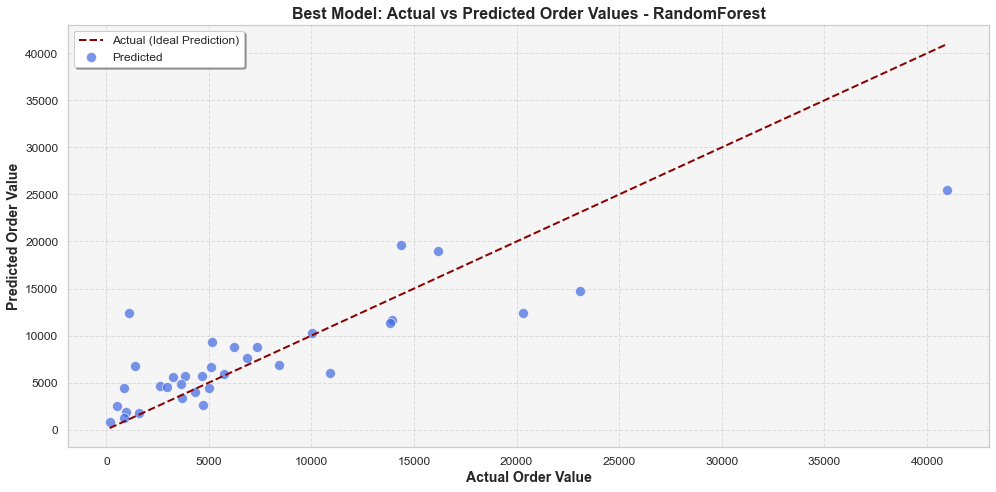

In [19]:
# Predict using the best model
y_pred_tuned = best_model_tuned.predict(X_test)

# Prepare data for plotting
results_best_model = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_tuned})

# Plotting
plt.figure(figsize=(14, 7))

# Scatter plot for predicted vs actual values
sns.scatterplot(x='Actual', y='Predicted', data=results_best_model, color='royalblue', s=100, edgecolor='w', alpha=0.7, label='Predicted')

# Line plot for ideal prediction
sns.lineplot(x=results_best_model['Actual'], y=results_best_model['Actual'], color='darkred', linewidth=2, linestyle='--', label='Actual (Ideal Prediction)')

# Enhancing plot appearance
plt.title(f'Best Model: Actual vs Predicted Order Values - {best_model_name}', fontsize=16, fontweight='bold')
plt.xlabel('Actual Order Value', fontsize=14, fontweight='bold')
plt.ylabel('Predicted Order Value', fontsize=14, fontweight='bold')

# Adding gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Customizing the legend
plt.legend(loc='upper left', fontsize=12, frameon=True, shadow=True)

# Customizing tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding a background color
plt.gca().set_facecolor('whitesmoke')

# Adjust layout to prevent clipping
plt.tight_layout()

plt.show()

## Comparing the initial and tuned model

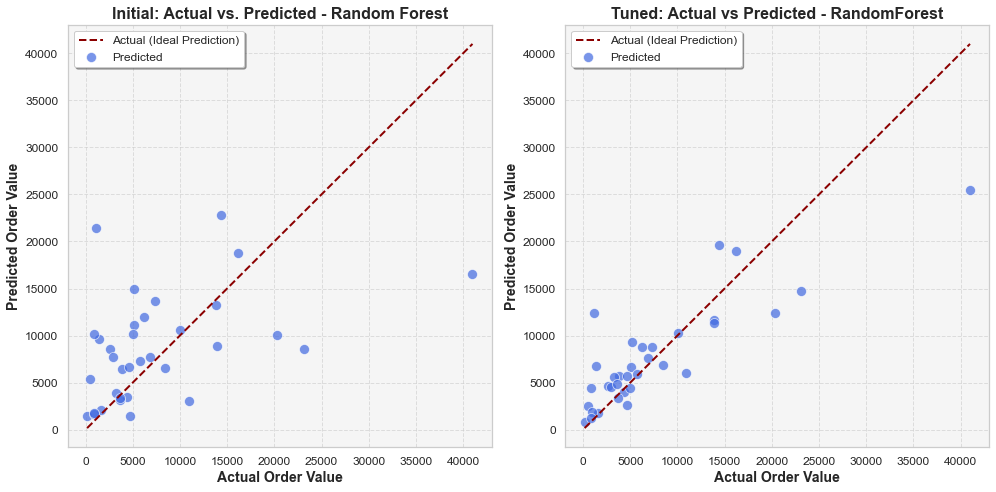

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Predict using the best model
y_pred_initial = best_model_initial.predict(X_test)

# Prepare data for plotting
results_initial = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_initial})

# Predict using the best model
y_pred_tuned = best_model_tuned.predict(X_test)

# Prepare data for plotting
results_best_model = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_tuned})

# Create a figure with 2 subplots
plt.figure(figsize=(14, 7))

# Plot for initial model
plt.subplot(1, 2, 1)
sns.scatterplot(x='Actual', y='Predicted', data=results_initial, color='royalblue', s=100, edgecolor='w', alpha=0.7, label='Predicted')
sns.lineplot(x=results_initial['Actual'], y=results_initial['Actual'], color='darkred', linewidth=2, linestyle='--', label='Actual (Ideal Prediction)')
plt.title(f'Initial: Actual vs. Predicted - {model_initial}', fontsize=16, fontweight='bold')
plt.xlabel('Actual Order Value', fontsize=14, fontweight='bold')
plt.ylabel('Predicted Order Value', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left', fontsize=12, frameon=True, shadow=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().set_facecolor('whitesmoke')

# Plot for best model
plt.subplot(1, 2, 2)
sns.scatterplot(x='Actual', y='Predicted', data=results_best_model, color='royalblue', s=100, edgecolor='w', alpha=0.7, label='Predicted')
sns.lineplot(x=results_best_model['Actual'], y=results_best_model['Actual'], color='darkred', linewidth=2, linestyle='--', label='Actual (Ideal Prediction)')
plt.title(f'Tuned: Actual vs Predicted - {best_model_name}', fontsize=16, fontweight='bold')
plt.xlabel('Actual Order Value', fontsize=14, fontweight='bold')
plt.ylabel('Predicted Order Value', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left', fontsize=12, frameon=True, shadow=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().set_facecolor('whitesmoke')

# Adjust layout to prevent clipping
plt.tight_layout()

plt.show()

## Forecasting

In [21]:
import pandas as pd

# Example new data
future_data = pd.DataFrame({
    'Year': [2024, 2024],
    'Month': [11, 10],
    'Discount Applied': [0.3, 0.2],
    'Order Quantity': [150, 300]
})


# Predict future order values
predicted_order_values = best_model_tuned.predict(future_data)
predicted_order_values.tolist()

[15133.58830952381, 17415.50950047619]

# Optimization


In [23]:
warehouse_inventory = data.groupby('WarehouseCode')['Order Quantity'].sum().to_dict()

In [24]:
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpInteger, value

# Define the new order's details
new_order = {
    'OrderNumber': 'SO - NEW001',
    'WarehouseCode': None,  # This will be determined by the optimization
    'OrderDate': pd.to_datetime('2023-01-01'),  # Example date
    'DeliveryDate': pd.to_datetime('2023-01-10'),  # Example date
    'Order Quantity': 10,
    'FulfillmentTime': None  # This will be calculated
}

# Append the new order to the existing data or process it separately
# Calculate FulfillmentTime for the new order
new_order['Fulfillment Days'] = (new_order['DeliveryDate'] - new_order['OrderDate']).days

# Include the new order in your decision variables
order_ids = list(data['OrderNumber'].unique()) + [new_order['OrderNumber']]
warehouses = data['WarehouseCode'].unique()

# Create optimization problem
prob = LpProblem("Order_Fulfillment_Optimization", LpMinimize)

# Decision Variables: Assign orders to warehouses
x = LpVariable.dicts("assign", ((order, warehouse) for order in order_ids for warehouse in warehouses), 
                     cat=LpInteger, lowBound=0, upBound=1)

# Objective function: Minimize total fulfillment time including the new order
prob += lpSum([x[(order, warehouse)] * (
    data[(data['OrderNumber'] == order) & 
         (data['WarehouseCode'] == warehouse)]['Fulfillment Days'].values[0]
    if len(data[(data['OrderNumber'] == order) & (data['WarehouseCode'] == warehouse)]['Fulfillment Days'].values) > 0
    else new_order['Fulfillment Days'])
    for order in order_ids for warehouse in warehouses
    if order != new_order['OrderNumber'] or len(data[(data['OrderNumber'] == order) & (data['WarehouseCode'] == warehouse)]['Fulfillment Days'].values) > 0])

# Constraints:
# 1. Each order is fulfilled by exactly one warehouse
for order in order_ids:
    prob += lpSum([x[(order, warehouse)] for warehouse in warehouses]) == 1

# 2. Ensure warehouse has enough inventory (if inventory data is available)
for warehouse in warehouses:
    prob += lpSum([x[(order, warehouse)] * (
        data[data['OrderNumber'] == order]['Order Quantity'].values[0]
        if order != new_order['OrderNumber'] else new_order['Order Quantity'])
        for order in order_ids]) <= warehouse_inventory[warehouse]

# Solve the optimization problem
prob.solve()

# Determine the warehouse for the new order
for warehouse in warehouses:
    if x[(new_order['OrderNumber'], warehouse)].value() == 1:
        new_order['WarehouseCode'] = warehouse
        print(f"New order {new_order['OrderNumber']} will be fulfilled from Warehouse {warehouse}")

# Output the warehouse for the new order
print(f"New order should be fulfilled from: {new_order['WarehouseCode']}")



New order SO - NEW001 will be fulfilled from Warehouse WARE-NMK1003
New order should be fulfilled from: WARE-NMK1003
